In [1]:
import numpy as np
import pandas as pd
import glob as gb
import re
import matplotlib.pyplot as plt
import pprint as pp
import os
from scipy import signal
from cycler import cycler
from scipy.optimize import curve_fit

%matplotlib notebook

# Helper Functions

In [2]:
def getSample(file):
    # Get smple name from file
    sample = os.path.basename(file)
    sample = os.path.splitext(sample)[0]
    return sample

def getSampleNo(file):
    # Get sample number 
    sample = os.path.basename(file)
    sample = os.path.splitext(sample)[0]
    # For files with underscore
    sample = sample.split('_')[0]
    return int(sample[1:])

# Lifetime function
def model_func(t, a, b, c):
    return a*np.exp(-t/b)+c

def getLifetime(time, intensity, f):
    try:
        guess = [max(intensity), 10, min(intensity)]
        popt, pcov = curve_fit(model_func, time, intensity, guess)
        return popt[1]
    except:
        print(f + ' did not fit a single exp :(')
        return np.NaN

# Lifetimes

In [22]:
# select files to analyse
files = gb.glob('./Lifetime/*.txt')
files = sorted(files, key=lambda x: getSampleNo(x))

In [23]:
# Select the required pump
pump = 0.1
files = [x for x in files if '_' not in x ]  # For 100us pump
# files = [x for x in files if '_100ms' in x ]

# Individual
files = [x for x in files if 'T2.' in x ]

<IPython.core.display.Javascript object>


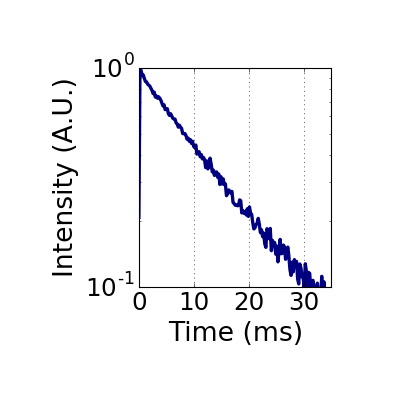

In [42]:
# Plot data
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

# Set colour cycle for lines
n = len(files) # Number of colors
new_colors = [plt.get_cmap('jet')(1. * i/n) for i in range(n)]
ax.set_prop_cycle(cycler('color', new_colors))

for f in files:
    data = np.genfromtxt(fname=f, delimiter=',', dtype=float, skip_header=10, usecols=(0,1))
    time = data[:,0]/1E6  # Convert time from us to ms
    intensity = data[:,1]
    
    # Normalise
    intensity -= min(intensity)
    intensity /= max(intensity)

    # Shift time axis to account for the pump
    time -= pump

    # Optional: drop the data before the pump
#     ind = np.where(time>=0)
#     time = time[ind]
#     intensity = intensity[ind]
    
#     ax.plot(time, intensity, label=getSample(f))
    ax.semilogy(time, intensity, label=getSample(f), linewidth=3)

# plt.legend(prop={'size': 12}, ncol=4, loc='best')
plt.xlim(0, 35)
plt.ylim(0.1, 1)
plt.xlabel('Time (ms)', fontsize=24)
plt.ylabel('Intensity (A.U.)', fontsize=24)
plt.yticks(fontsize=22); 
plt.xticks(fontsize=22)
# plt.title('Lifetime of T-series samples with %sms pump.' % pump)
plt.tight_layout(pad=4)
plt.grid()
ax.xaxis.set_ticks([0,10,20,30])
# # Shrink current axis by 20%
# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.6, box.height])
# plt.legend(ncol=2, loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('./Lifetime/plots/lifetime_' + getSample(f) + '.png', dpi=300)

# Spectrum

In [16]:
files = gb.glob('./Spectrum/PlottingData/*.txt')
files = sorted(files, key=lambda x: getSampleNo(x))

In [17]:
# Select subset (optional)
files = [x for x in files if 'T2.' in x ]

<IPython.core.display.Javascript object>


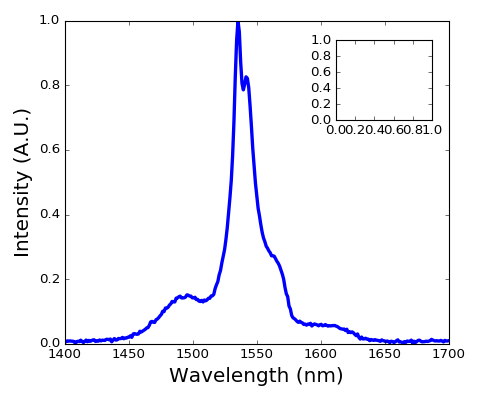

In [18]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

for f in files:
    # Load data
    data = np.genfromtxt(fname=f, delimiter=',', dtype=float, skip_header=22, usecols=(0,1))
    wavelength = data[:,0]
    intensity = data[:,1]

    # Normalise
    intensity -= min(intensity)
    intensity /= max(intensity)

    ax.plot(wavelength, intensity, label=getSample(f), linewidth=3)

    # plt.legend()
    plt.xlabel('Wavelength (nm)', fontsize=18)
    plt.ylabel('Intensity (A.U.)', fontsize=18)
    plt.yticks(fontsize=12); 
    plt.xticks(fontsize=12)
    plt.xlim(min(wavelength),max(wavelength))
    plt.tight_layout()
    plt.savefig('./Spectrum/plots/spectrum_' + getSample(f) + '.png', dpi=300)

# Pandas Dataframe

In [3]:
# Get samples from file names
sample_list=[getSample(x) for x in files]

# Index
index = [int(x[1:]) for x in sample_list]

d = {'sample' : sample_list}

df = pd.DataFrame(d, index=index)
df.sort_index(inplace=True)
df = df.set_index('sample')

NameError: name 'files' is not defined

In [4]:
# Create colormap for plotting
n = len(sample_list) # Number of colors
new_colors = [plt.get_cmap('jet')(1. * i/n) for i in range(n)]
plt.rc('axes', prop_cycle=(cycler('color', new_colors)))

NameError: name 'sample_list' is not defined

In [48]:
# Fit lifetime and add to dataframe
tau = []
sample = []
for f in files:
    data = np.genfromtxt(fname=f, delimiter=',', dtype=float, skip_header=22, usecols=(0,1))
    time = data[:,0]/1E6  # Convert to ms
    intensity = data[:,1]
    
    # Sample
    sample.append(getSample(f))

    # Normalise
    intensity -= min(intensity)
    intensity /= max(intensity)

    # Shift time axis to account for the pump
    time -= 2*pump

    # Optional: drop the data before the pump
    ind = np.where(time>=0)
    time = time[ind]
    intensity = intensity[ind]
    
    tau.append(getLifetime(time, intensity, f))

df['Lifetime'] = pd.Series(tau, index=sample)  

In [49]:
df.head()

,MaxIntensity,TotalIntensity,Lifetime
sample,,,
T1,168200.0,15500290.0,12.582230
T2,165300.0,15583850.0,12.478841
T3,132600.0,14499530.0,12.041918
T4,160600.0,16723680.0,1.541385
T5,119400.0,14065800.0,12.971974


In [54]:
# Save Dataframe
df.to_csv('Spectrum_dataframe.csv')
# To load
# pd.read_csv('dataframe.csv', index_col=0) 